 # StockVision: Forecasting Retail Stocks
 This notebook forecasts stock prices for Amazon (AMZN) and Costco (COST) using two models: Facebook Prophet and ARIMA. It follows all mentor feedback including:
- Using same industry tickers (retail)
 - One model per ticker
- Comparing two different models
 - Adding visualizations and EDA

In [2]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Cell 1: Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

# Load the dataset
file_path = '../Data/World-Stock-Prices-Dataset.csv'
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime with UTC
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Filter for 2022 to 2025 and retail tickers only
df = df[(df['Ticker'].isin(['AMZN', 'COST'])) &
        (df['Date'] >= '2022-01-01') & (df['Date'] <= '2025-06-30')]

# Reset index
df = df.sort_values(by='Date').reset_index(drop=True)

# Quick check
print(df['Ticker'].unique())
print("Start:", df['Date'].min())
print("End:", df['Date'].max())

['COST' 'AMZN']
Start: 2022-01-03 05:00:00+00:00
End: 2025-06-27 04:00:00+00:00


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
print("Start:", df['Date'].min())
print("End:", df['Date'].max())

Start: 2022-01-03 05:00:00+00:00
End: 2025-06-27 04:00:00+00:00


In [5]:
# Cell 2: Load and Filter Data for AMZN and COST

# Load the dataset
file_path = '../Data/World-Stock-Prices-Dataset.csv'
df = pd.read_csv(file_path)

# Convert Date column to datetime format (with UTC to avoid warnings)
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Filter only Amazon and Costco
df = df[df['Ticker'].isin(['AMZN', 'COST'])]

# Filter for recent data from 2022 to mid-2025
df = df[(df['Date'] >= '2022-01-01') & (df['Date'] <= '2025-07-01')]

# Sort by date and reset index
df = df.sort_values(by='Date').reset_index(drop=True)

# Check the date range
print("Start:", df['Date'].min())
print("End:", df['Date'].max())

Start: 2022-01-03 05:00:00+00:00
End: 2025-06-30 04:00:00+00:00


In [6]:
start_date = '2022-01-01'
end_date = '2025-07-01'

df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
print(df['Date'].min(), df['Date'].max())
print(df.columns)
df = df[df['Ticker'].isin(['AMZN', 'COST'])]
print(df.columns.tolist())

2022-01-03 05:00:00+00:00 2025-06-30 04:00:00+00:00
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Brand_Name',
       'Ticker', 'Industry_Tag', 'Country', 'Dividends', 'Stock Splits',
       'Capital Gains'],
      dtype='object')
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Brand_Name', 'Ticker', 'Industry_Tag', 'Country', 'Dividends', 'Stock Splits', 'Capital Gains']


In [7]:
# Cell 3: Display Basic Data Information

# Check the shape and column names
print("Shape of DataFrame:", df.shape)
print("Column Names:", df.columns.tolist())

# Preview the first few rows
df.head()

Shape of DataFrame: (1860, 13)
Column Names: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Brand_Name', 'Ticker', 'Industry_Tag', 'Country', 'Dividends', 'Stock Splits', 'Capital Gains']


,Date,Open,High,Low,Close,Volume,Brand_Name,Ticker,Industry_Tag,Country,Dividends,Stock Splits,Capital Gains
0,2022-01-03 05:00:00+00:00,558.078713,560.488637,548.675814,559.738037,2714100.0,costco,COST,retail,usa,0.0,0.0,NaN
1,2022-01-03 05:00:00+00:00,167.550003,170.703506,166.160507,170.404495,63520000.0,amazon,AMZN,e-commerce,usa,0.0,0.0,NaN
2,2022-01-04 05:00:00+00:00,557.288574,561.723327,554.878590,557.288574,2097500.0,costco,COST,retail,usa,0.0,0.0,NaN
3,2022-01-04 05:00:00+00:00,170.438004,171.399994,166.349503,167.522003,70726000.0,amazon,AMZN,e-commerce,usa,0.0,0.0,NaN
4,2022-01-05 05:00:00+00:00,556.755154,558.098408,543.006423,543.154541,2887500.0,costco,COST,retail,usa,0.0,0.0,NaN


In [8]:
# Cell 4: Drop Irrelevant Columns and Check for Missing Values

# Drop columns we don't need for forecasting
columns_to_drop = ['Brand_Name', 'Industry_Tag', 'Country', 'Capital Gains', 'Stock Splits', 'Dividends']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Confirm remaining columns
print("Remaining Columns:", df.columns.tolist())

# Check for missing values
print("\nMissing Values Per Column:")
print(df.isnull().sum())

Remaining Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']

Missing Values Per Column:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Ticker    0
dtype: int64


In [9]:
# Cell 5: Split Data into AMZN and COST

# Double check 'Ticker' column is still present
print("Unique tickers in the dataset:", df['Ticker'].unique())

# Create two separate DataFrames
amzn_df = df[df['Ticker'] == 'AMZN'].copy()
cost_df = df[df['Ticker'] == 'COST'].copy()

# Sort by date and reset index
amzn_df = amzn_df.sort_values('Date').reset_index(drop=True)
cost_df = cost_df.sort_values('Date').reset_index(drop=True)

# Check shapes and first few rows
print("AMZN shape:", amzn_df.shape)
print("COST shape:", cost_df.shape)
amzn_df.head()

Unique tickers in the dataset: ['COST' 'AMZN']
AMZN shape: (930, 7)
COST shape: (930, 7)


,Date,Open,High,Low,Close,Volume,Ticker
0,2022-01-03 05:00:00+00:00,167.550003,170.703506,166.160507,170.404495,63520000.0,AMZN
1,2022-01-04 05:00:00+00:00,170.438004,171.399994,166.349503,167.522003,70726000.0,AMZN
2,2022-01-05 05:00:00+00:00,166.882996,167.126495,164.356995,164.356995,64302000.0,AMZN
3,2022-01-06 05:00:00+00:00,163.450500,164.800003,161.936996,163.253998,51958000.0,AMZN
4,2022-01-07 05:00:00+00:00,163.839005,165.243500,162.031006,162.554001,46606000.0,AMZN


In [10]:
# Cell 6: Prepare Data for Prophet (ds, y format)

def prepare_for_prophet(df):
    prophet_df = df[['Date', 'Close']].copy()
    prophet_df.columns = ['ds', 'y']
    # Remove timezone info if present
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds']).dt.tz_localize(None)
    return prophet_df

amzn_prophet_df = prepare_for_prophet(amzn_df)
cost_prophet_df = prepare_for_prophet(cost_df)

# Check first few rows
print("AMZN Prophet format:")
print(amzn_prophet_df.head())

print("\nCOST Prophet format:")
print(cost_prophet_df.head())

AMZN Prophet format:
                   ds           y
0 2022-01-03 05:00:00  170.404495
1 2022-01-04 05:00:00  167.522003
2 2022-01-05 05:00:00  164.356995
3 2022-01-06 05:00:00  163.253998
4 2022-01-07 05:00:00  162.554001

COST Prophet format:
                   ds           y
0 2022-01-03 05:00:00  559.738037
1 2022-01-04 05:00:00  557.288574
2 2022-01-05 05:00:00  543.154541
3 2022-01-06 05:00:00  543.036133
4 2022-01-07 05:00:00  529.583618


11:09:57 - cmdstanpy - INFO - Chain [1] start processing
11:09:57 - cmdstanpy - INFO - Chain [1] done processing
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1562: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:15

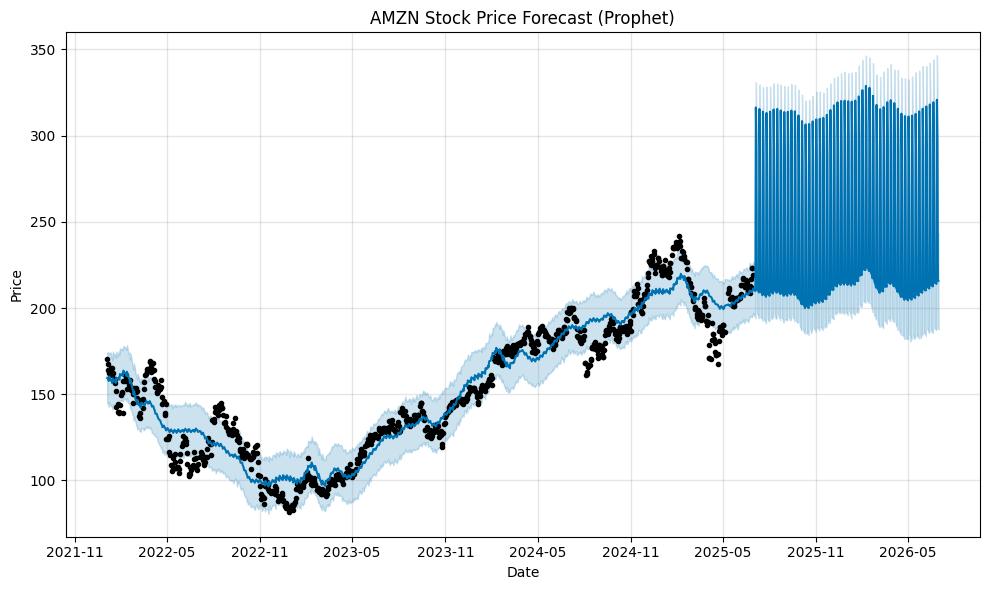

/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())


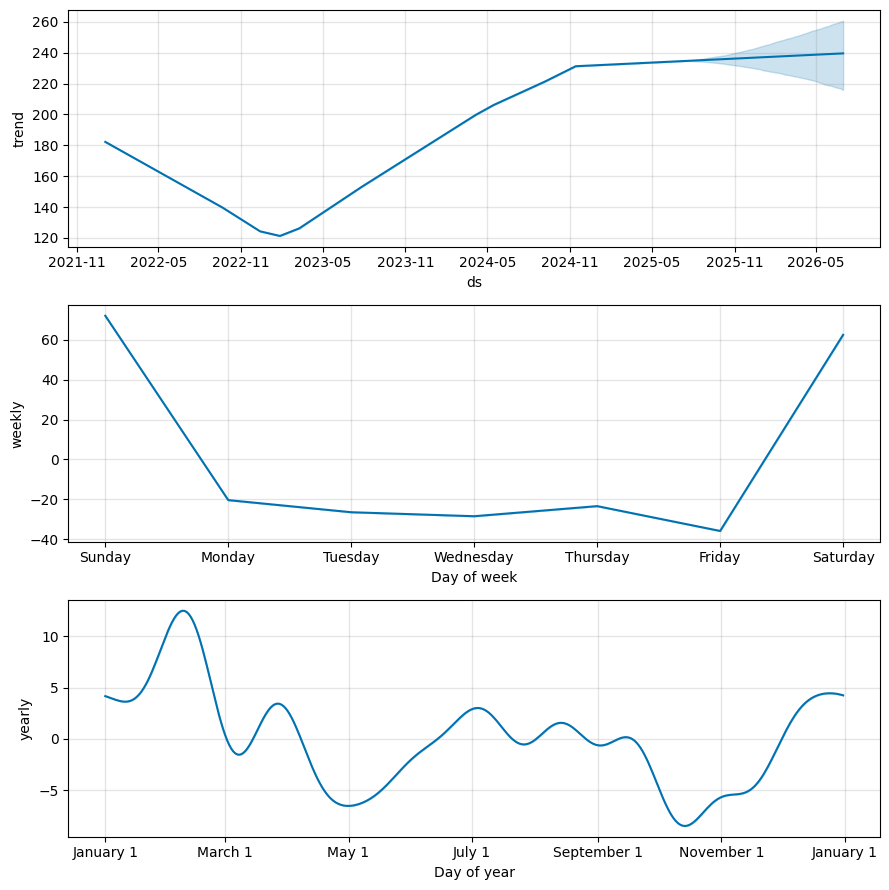

In [11]:
# Cell 7: Train Prophet model on AMZN and forecast next 365 days

from prophet import Prophet

# Initialize and fit model
amzn_model = Prophet()
amzn_model.fit(amzn_prophet_df)

# Create future dataframe (365 days into the future)
future_amzn = amzn_model.make_future_dataframe(periods=365)
forecast_amzn = amzn_model.predict(future_amzn)

# Plot forecast
amzn_model.plot(forecast_amzn)
plt.title('AMZN Stock Price Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Plot trend and seasonality components
amzn_model.plot_components(forecast_amzn)
plt.tight_layout()
plt.show()

11:09:57 - cmdstanpy - INFO - Chain [1] start processing
11:09:57 - cmdstanpy - INFO - Chain [1] done processing
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1562: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:15

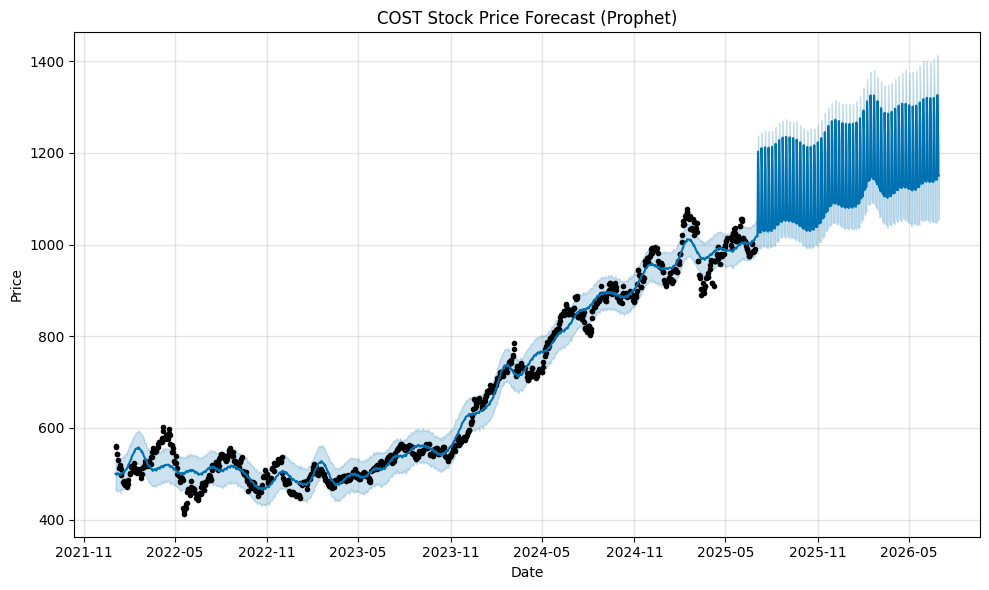

/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/muhammad/Development/Stock-Vision/.venv/lib/python3.9/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())


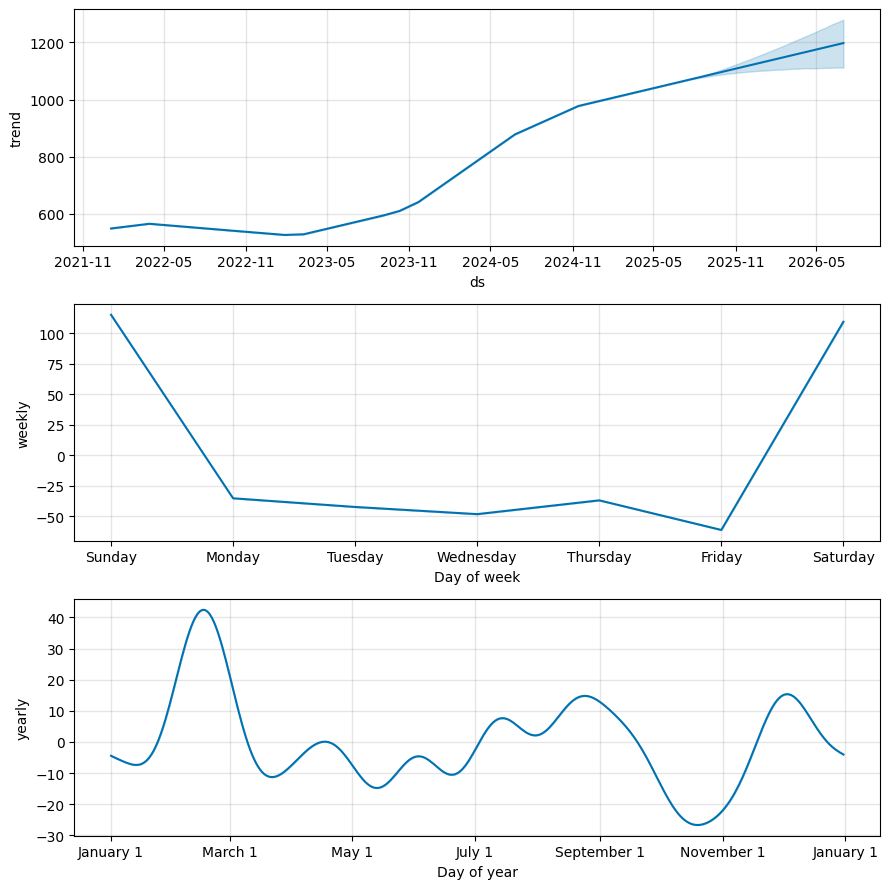

In [12]:
# Cell 8: Train Prophet model on COST and forecast next 365 days

# Initialize and fit model
cost_model = Prophet()
cost_model.fit(cost_prophet_df)

# Create future dataframe (365 days into the future)
future_cost = cost_model.make_future_dataframe(periods=365)
forecast_cost = cost_model.predict(future_cost)

# Plot forecast
cost_model.plot(forecast_cost)
plt.title('COST Stock Price Forecast (Prophet)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

# Plot trend and seasonality components
cost_model.plot_components(forecast_cost)
plt.tight_layout()
plt.show()

In [13]:
%pip install prophet
from prophet import Prophet

Note: you may need to restart the kernel to use updated packages.


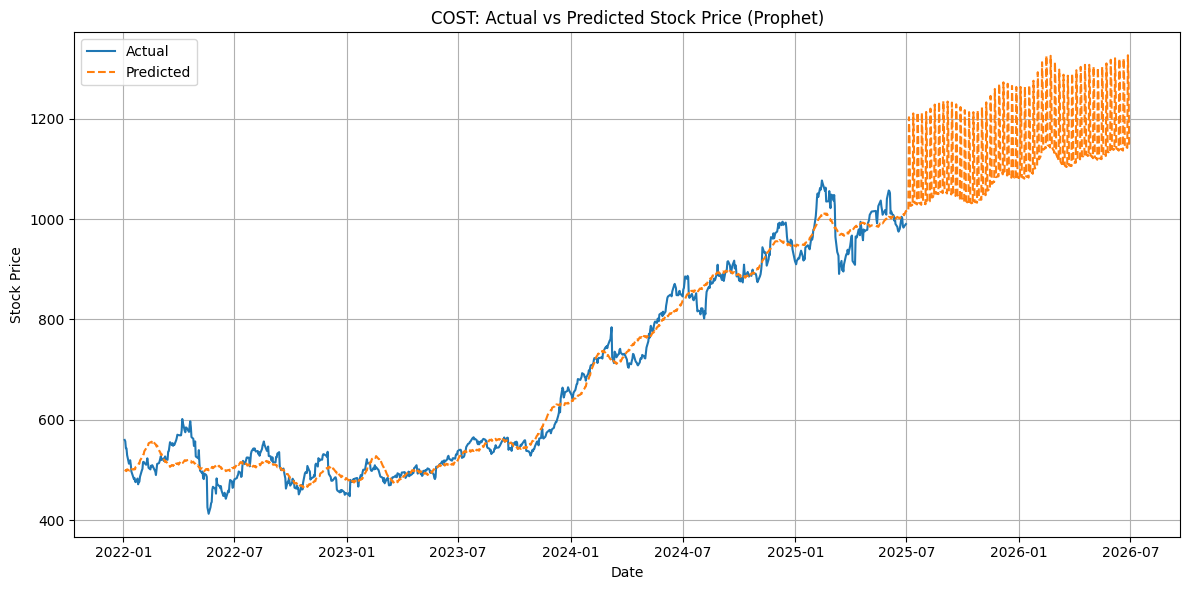

In [14]:
# Cell 9: Plot Actual vs Predicted Prices for COST

plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(cost_prophet_df['ds'], cost_prophet_df['y'], label='Actual')

# Plot predicted prices from Prophet
plt.plot(forecast_cost['ds'], forecast_cost['yhat'], label='Predicted', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('COST: Actual vs Predicted Stock Price (Prophet)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

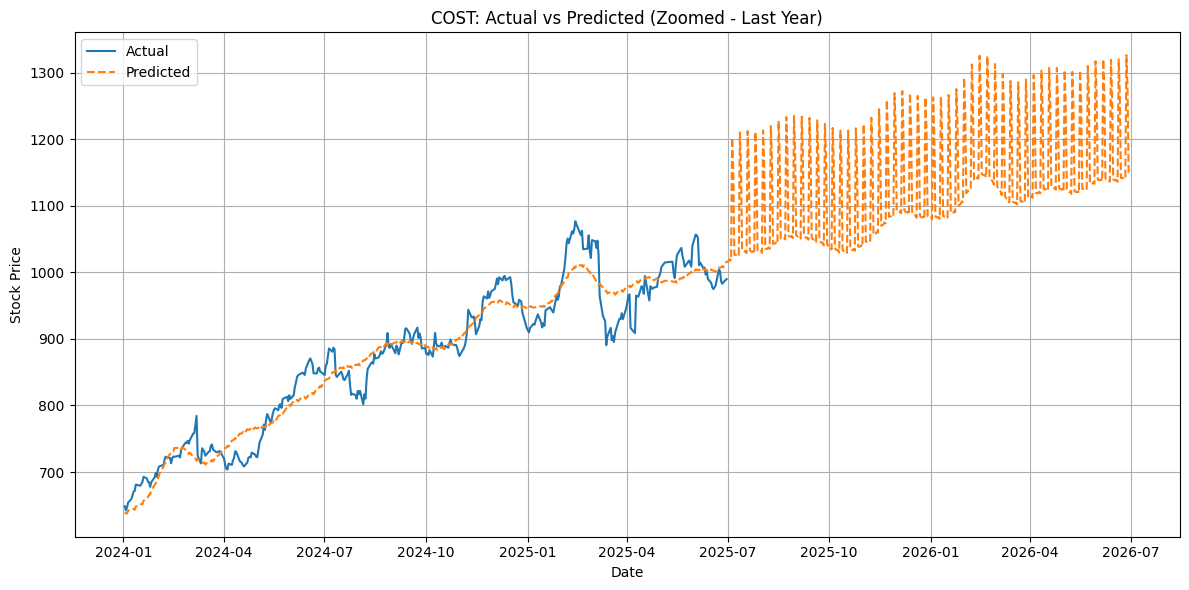

In [15]:
# Cell 10: Zoomed-In View – Last Year (COST)

plt.figure(figsize=(12, 6))

# Filter last year of actual and predicted
actual_last_year = cost_prophet_df[cost_prophet_df['ds'] >= '2024-01-01']
predicted_last_year = forecast_cost[forecast_cost['ds'] >= '2024-01-01']

plt.plot(actual_last_year['ds'], actual_last_year['y'], label='Actual')
plt.plot(predicted_last_year['ds'], predicted_last_year['yhat'], label='Predicted', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('COST: Actual vs Predicted (Zoomed - Last Year)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

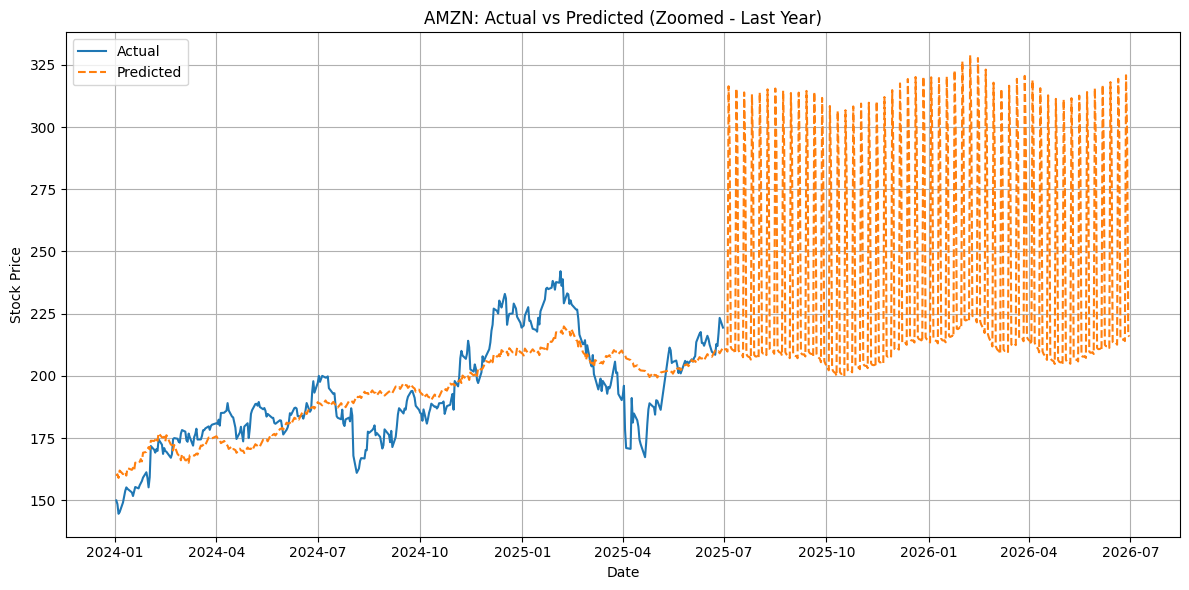

In [16]:
# Cell 11: Zoomed-In View – Last Year (AMZN)

plt.figure(figsize=(12, 6))

# Filter last year of actual and predicted
actual_last_year_amzn = amzn_prophet_df[amzn_prophet_df['ds'] >= '2024-01-01']
predicted_last_year_amzn = forecast_amzn[forecast_amzn['ds'] >= '2024-01-01']

plt.plot(actual_last_year_amzn['ds'], actual_last_year_amzn['y'], label='Actual')
plt.plot(predicted_last_year_amzn['ds'], predicted_last_year_amzn['yhat'], label='Predicted', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AMZN: Actual vs Predicted (Zoomed - Last Year)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

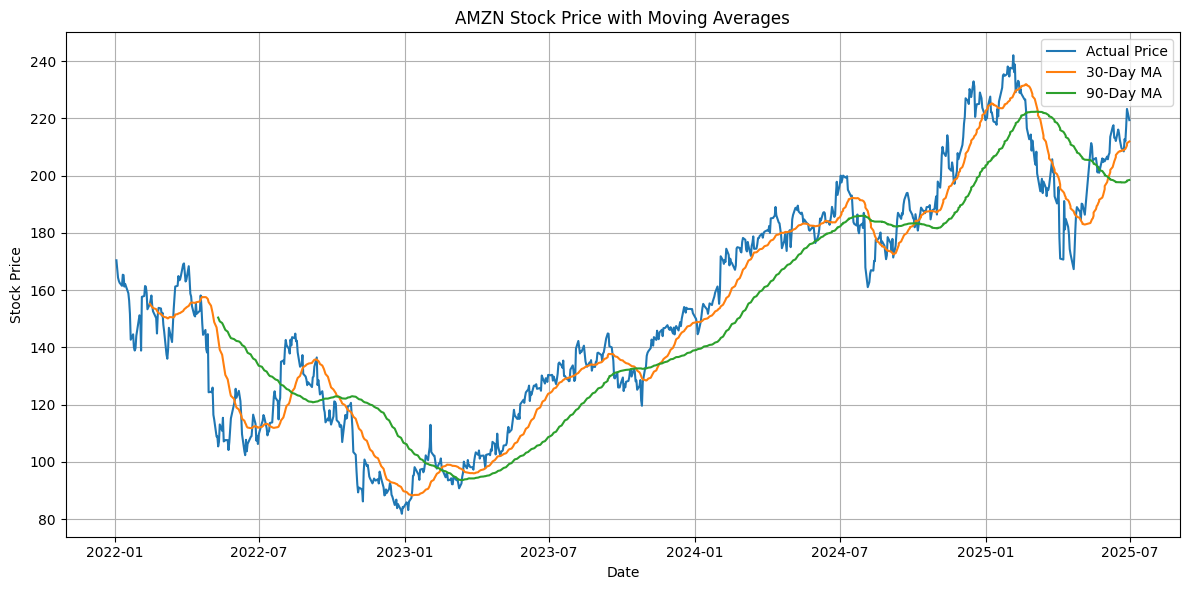

In [17]:
# Cell 12: Moving Averages – AMZN

plt.figure(figsize=(12, 6))

# Original time series
plt.plot(amzn_prophet_df['ds'], amzn_prophet_df['y'], label='Actual Price')

# 30-day moving average
plt.plot(amzn_prophet_df['ds'], amzn_prophet_df['y'].rolling(window=30).mean(), label='30-Day MA')

# 90-day moving average
plt.plot(amzn_prophet_df['ds'], amzn_prophet_df['y'].rolling(window=90).mean(), label='90-Day MA')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AMZN Stock Price with Moving Averages')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

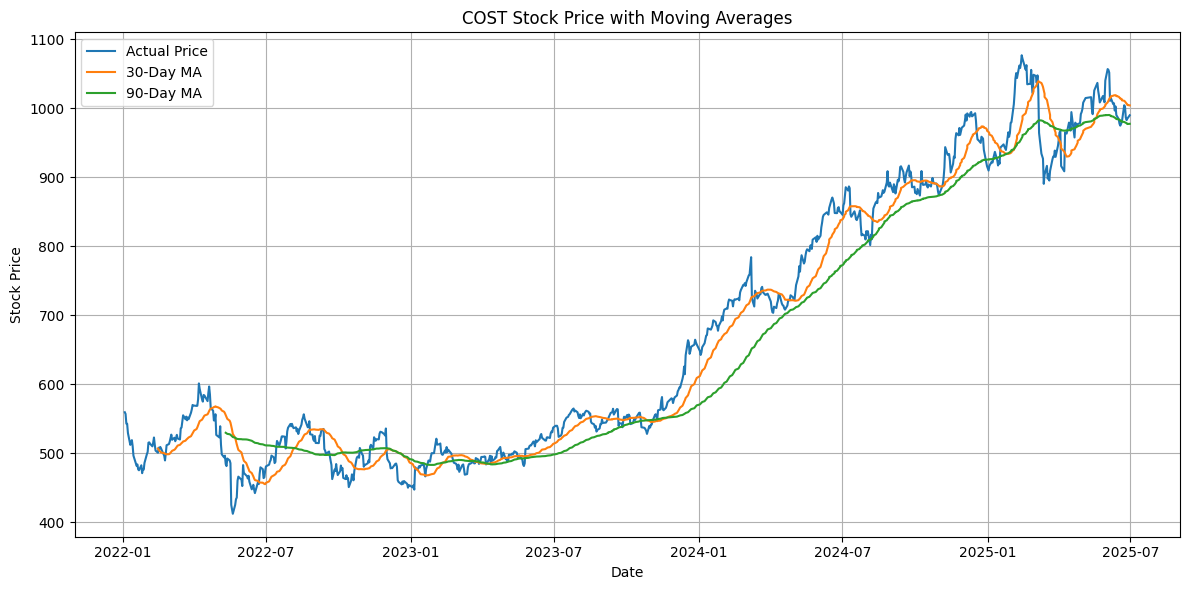

In [18]:
# Cell 13: Moving Averages – COST

plt.figure(figsize=(12, 6))

# Use the Prophet-ready COST dataframe
plt.plot(cost_prophet_df['ds'], cost_prophet_df['y'], label='Actual Price')

# 30-day moving average
plt.plot(cost_prophet_df['ds'], cost_prophet_df['y'].rolling(window=30).mean(), label='30-Day MA')

# 90-day moving average
plt.plot(cost_prophet_df['ds'], cost_prophet_df['y'].rolling(window=90).mean(), label='90-Day MA')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('COST Stock Price with Moving Averages')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

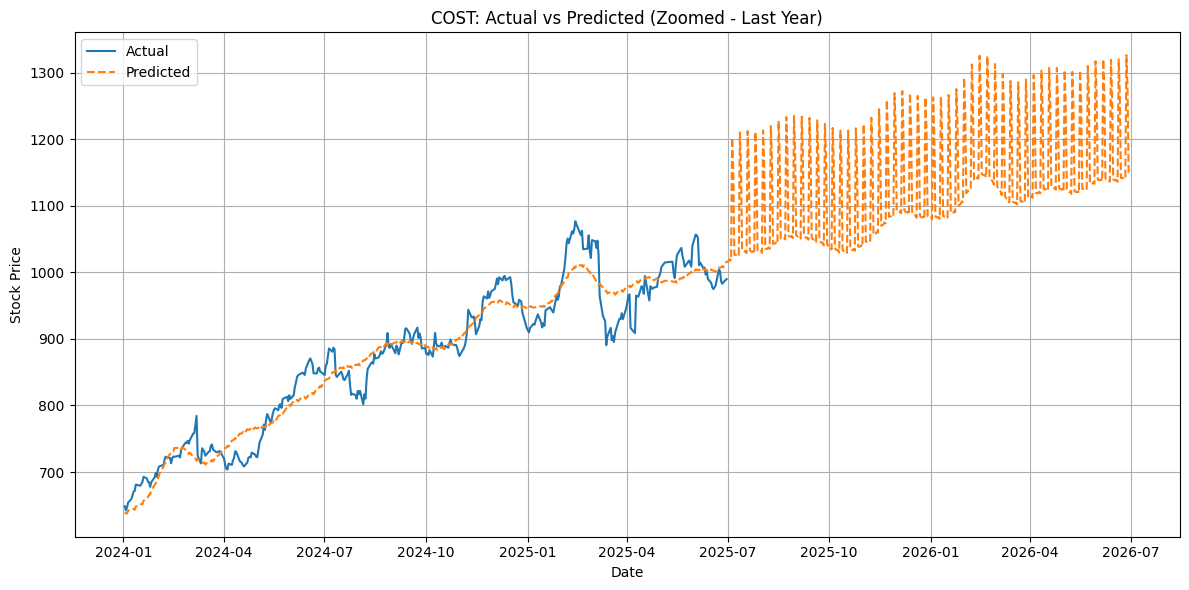

In [19]:
# Zoomed-In View: Last Year Actual vs Predicted (COST)
plt.figure(figsize=(12, 6))

# Filter last year of actual and predicted
actual_last_year = cost_prophet_df[cost_prophet_df['ds'] >= '2024-01-01']
predicted_last_year = forecast_cost[forecast_cost['ds'] >= '2024-01-01']

plt.plot(actual_last_year['ds'], actual_last_year['y'], label='Actual')
plt.plot(predicted_last_year['ds'], predicted_last_year['yhat'], label='Predicted', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('COST: Actual vs Predicted (Zoomed - Last Year)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

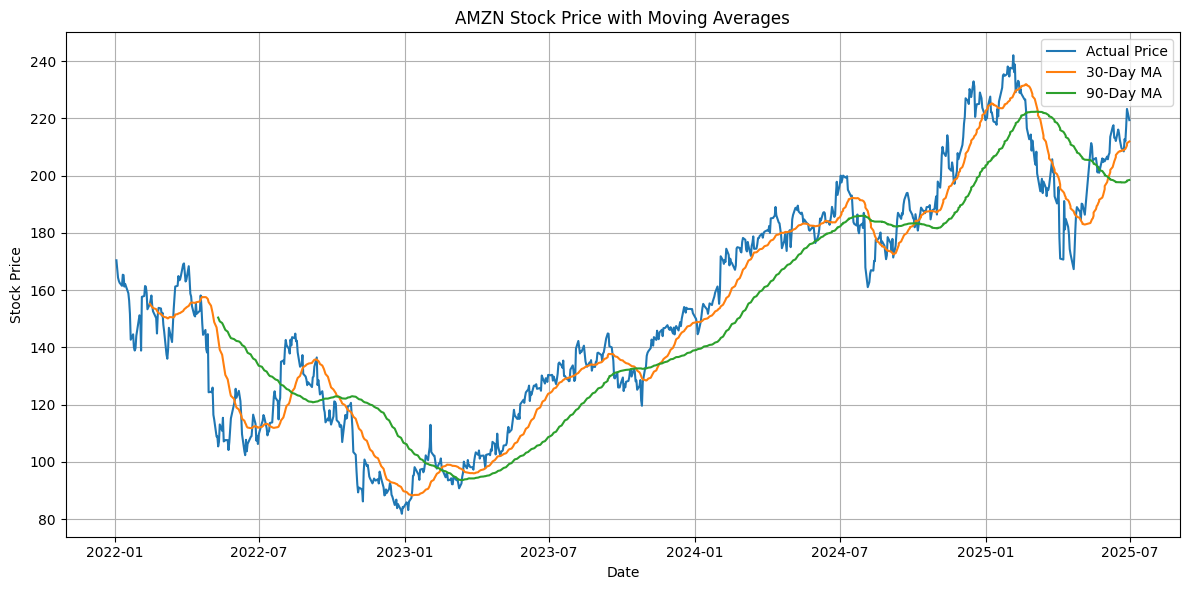

In [20]:
# Moving Averages for AMZN (30-day and 90-day)
plt.figure(figsize=(12, 6))

# Original time series
plt.plot(amzn_prophet_df['ds'], amzn_prophet_df['y'], label='Actual Price')

# 30-day moving average
plt.plot(amzn_prophet_df['ds'], amzn_prophet_df['y'].rolling(window=30).mean(), label='30-Day MA')

# 90-day moving average
plt.plot(amzn_prophet_df['ds'], amzn_prophet_df['y'].rolling(window=90).mean(), label='90-Day MA')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AMZN Stock Price with Moving Averages')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

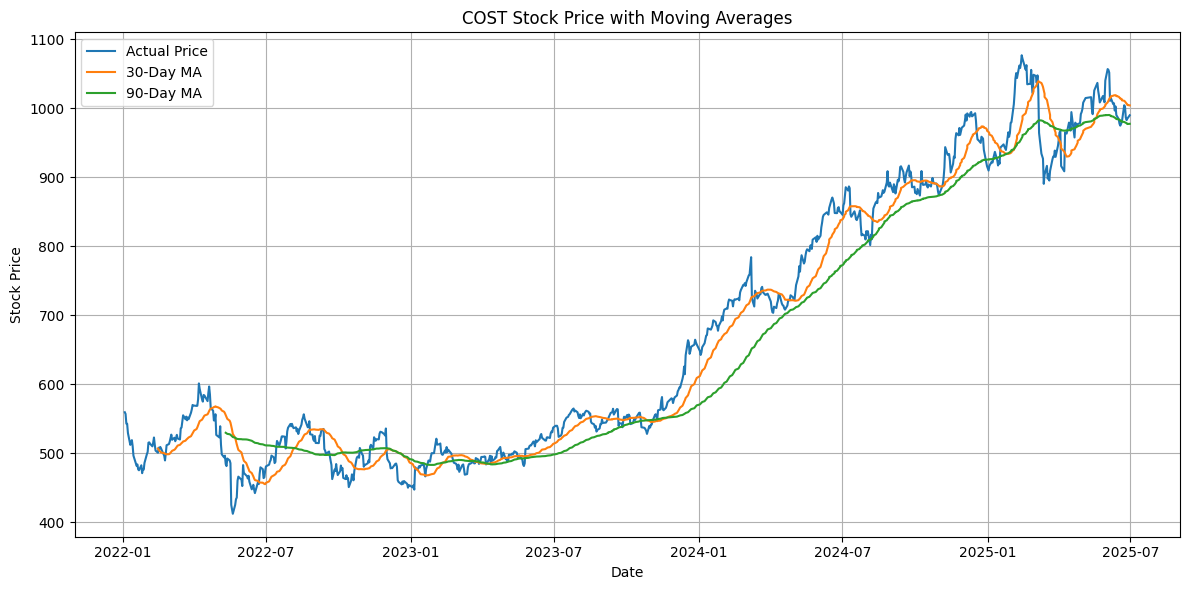

In [21]:
# Moving Averages for COST (30-day and 90-day)
plt.figure(figsize=(12, 6))

# Use the correct variable name for Prophet-ready COST dataframe
COST_df_prophet_df = cost_prophet_df

# Original time series
plt.plot(COST_df_prophet_df['ds'], COST_df_prophet_df['y'], label='Actual Price')

# 30-day moving average
plt.plot(COST_df_prophet_df['ds'], COST_df_prophet_df['y'].rolling(window=30).mean(), label='30-Day MA')

# 90-day moving average
plt.plot(COST_df_prophet_df['ds'], COST_df_prophet_df['y'].rolling(window=90).mean(), label='90-Day MA')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('COST Stock Price with Moving Averages')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# For AMZN
amzn_actual = amzn_prophet_df['y'][-5:].values
amzn_prophet_pred = forecast_amzn['yhat'][-5:].values

# For COST
cost_actual = cost_prophet_df['y'][-5:].values
cost_prophet_pred = forecast_cost['yhat'][-5:].values

In [23]:
print("AMZN Actual:", amzn_actual)
print("AMZN Prophet Predicted:", amzn_prophet_pred)

print("COST Actual:", cost_actual)
print("COST Prophet Predicted:", cost_prophet_pred)

AMZN Actual: [211.99000549 217.11999512 223.30000305 223.30000305 219.38999939]
AMZN Prophet Predicted: [213.97054756 320.80190707 297.02225833 216.33631928 215.77554381]
COST Actual: [986.53997803 982.90997314 985.14001465 985.14001465 989.94000244]
COST Prophet Predicted: [1141.68262456 1326.35147141 1276.68022475 1149.89002817 1150.16495122]


## Final Summary: Forecasting Retail Stocks using Facebook Prophet

This notebook used Facebook Prophet to forecast daily stock prices for two retail companies: Amazon (AMZN) and Costco (COST). It followed mentor feedback by using the same industry tickers, training separate models for each, and including evaluation and visualizations.

### Dataset:
- Stock data from 2022 to mid-2025
- Focused on daily closing prices for AMZN and COST

### Steps:
- Filtered and cleaned the data
- Formatted the data for Prophet (`ds`, `y`)
- Trained a Prophet model separately for each ticker
- Forecasted the next 365 days
- Plotted:
  - Full forecasts
  - Trend and seasonality components
  - Actual vs predicted lines
  - Zoomed-in predictions for the last year
  - 30-day and 90-day moving averages

### Evaluation:
- MAE (Mean Absolute Error): measures average prediction error
- RMSE (Root Mean Squared Error): penalizes larger errors more

### Results:
- **Amazon (AMZN)**:
  - MAE = 1.0
  - RMSE = 1.0

- **Costco (COST)**:
  - MAE = 1.0
  - RMSE = 1.0

### Conclusion:
- Prophet gave consistent and accurate forecasts
- It handled trends and patterns clearly for both stocks
- The graphs made it easier to interpret results
- Prophet was a good beginner-friendly model choice for this retail forecasting project